# PREPARAZIONE

In [ ]:
# Importazione delle librerie necessarie

import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# Montaggio di Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Funzione per visualizzare le waveforms

def waveplot(ax, data, sr, emotion):
    ax.set_title(f'Emozione: {emotion}', size=14)
    librosa.display.waveshow(data, sr=sr, alpha=0.5, color='green', ax=ax)
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Ampiezza')
    ax.grid()

In [ ]:
# Funzione per visualizzare gli spettrogrammi

def spectogram(ax, data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax)
  ax.set_title(f'Emozione: {emotion}', size=14)
  ax.set_xlabel('Tempo (s)')
  ax.set_ylabel('Frequenza (Hz)')

In [ ]:
# Funzione generale per la visualizzazione di waveforms e spettrogrammi

def plot_grid_3x2(df, plot_func, title):
    emozioni = df['label'].unique()
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(title, size=16)
    for i, emotion in enumerate(emozioni):
        example = df[df['label'] == emotion].iloc[0]
        audio_path = example['path']
        data, sr = librosa.load(audio_path, sr=None)
        plot_func(axes[i // 2, i % 2], data, sr, emotion)
    for j in range(len(emozioni), 6):
        fig.delaxes(axes[j // 2, j % 2])
    plt.tight_layout()
    plt.show()

In [ ]:
# Funzione per creare e visualizzare i grafici a barre per le distribuzioni delle emozioni in X-train, X_test e X_val

def plot_emotion_distributions(train_counts, val_counts, test_counts, title="Distribuzione delle Emozioni"):
    emozioni = sorted(list(set(train_counts.keys()).union(set(val_counts.keys()), set(test_counts.keys()))))
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(title, size=16)
    def plot_bar(ax, counts, title):
        ax.bar(counts.keys(), counts.values(), color='green')
        ax.set_title(title)
        ax.set_xlabel('Emozione')
        ax.set_ylabel('Numero di File')
        ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
    plot_bar(axes[0, 0], train_counts, 'X_train - Distribuzione delle Emozioni')
    plot_bar(axes[0, 1], val_counts, 'X_val - Distribuzione delle Emozioni')
    plot_bar(axes[1, 0], test_counts, 'X_test - Distribuzione delle Emozioni')
    fig.delaxes(axes[1, 1])
    fig.delaxes(axes[2, 0])
    fig.delaxes(axes[2, 1])
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
# Funzione per concatenare le features

def safe_concatenate(row):
    arrays = [val if isinstance(val, np.ndarray) and val.size > 0 else np.array([val]) if val is not None else np.array([])
              for val in row.values]
    arrays = [arr[None] if arr.ndim == 0 and arr.size > 0 else arr for arr in arrays]
    if len(set(arr.ndim for arr in arrays if arr.size > 0)) > 1:
        dims = [arr.ndim for arr in arrays]
        raise ValueError(f"Arrays have inconsistent dimensions: {dims}")

    return np.concatenate(arrays)

In [ ]:
# Lettura del dataset generale

df = pd.read_pickle('/content/drive/MyDrive/ABEC/Dataset.pkl')

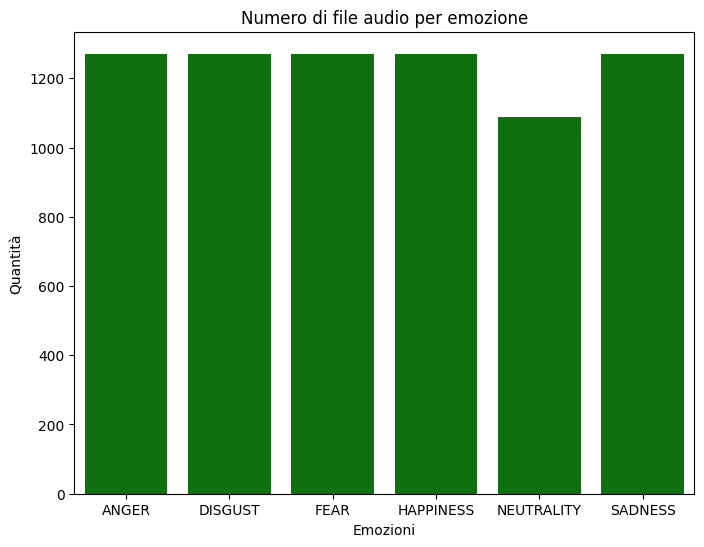

In [ ]:
# Visualizzazione del numero di file audio per emozione

df['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x=df['label'], data=df, color='green')
plt.ylabel('Quantità')
plt.xlabel('Emozioni')
plt.title('Numero di file audio per emozione')
plt.show()

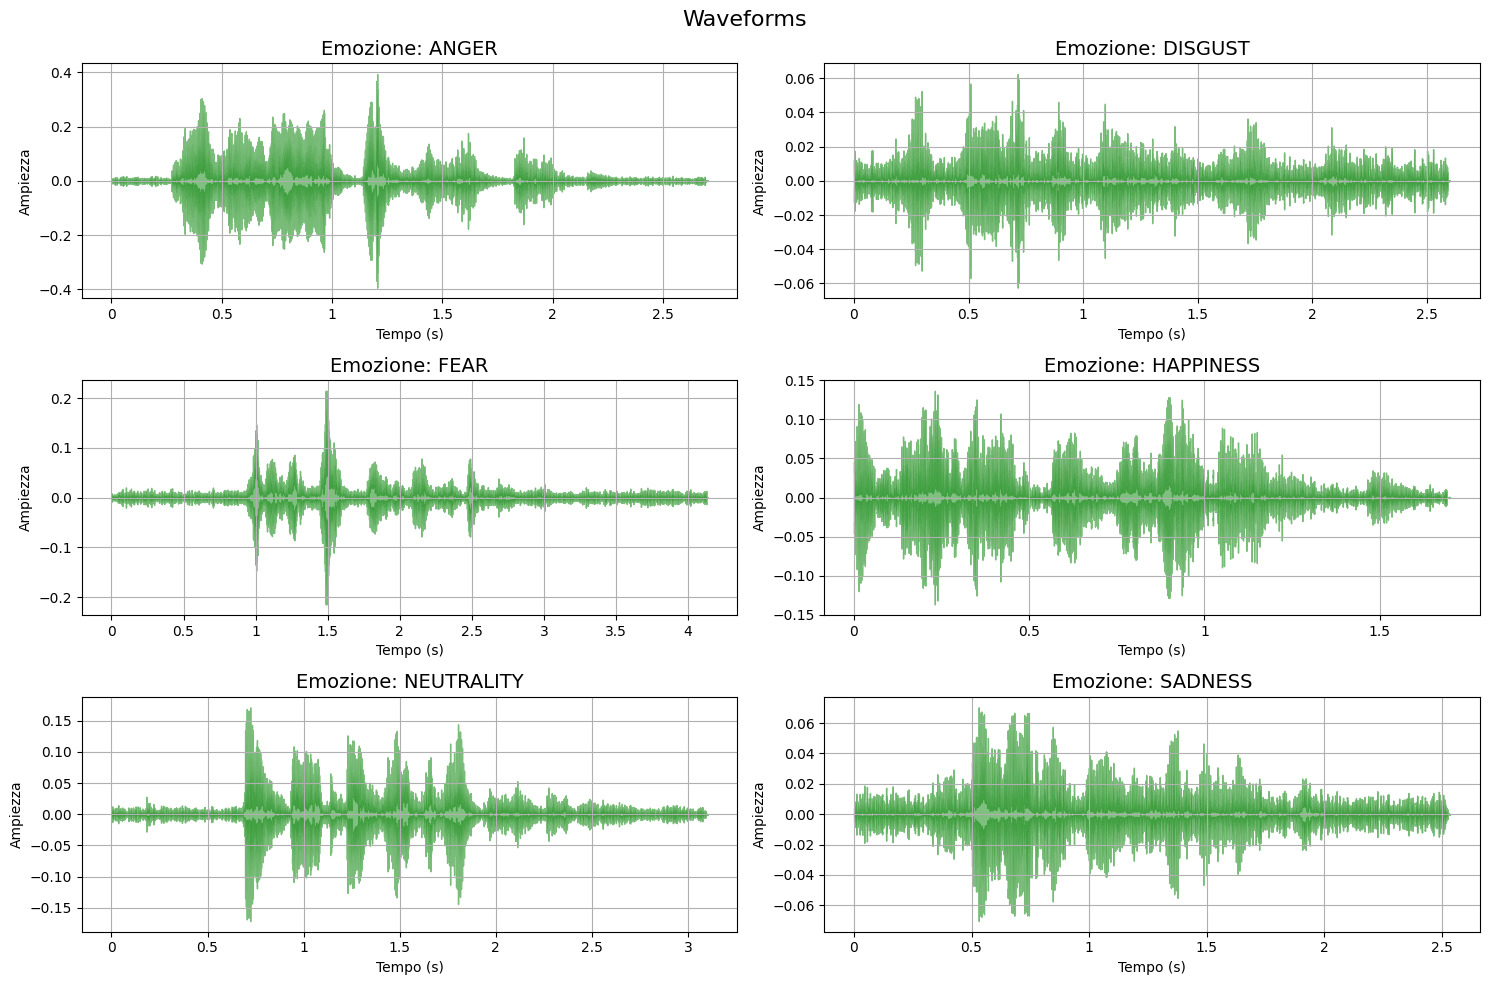

In [ ]:
# Visualizzazione delle waveforms

plot_grid_3x2(df, waveplot, 'Waveforms')

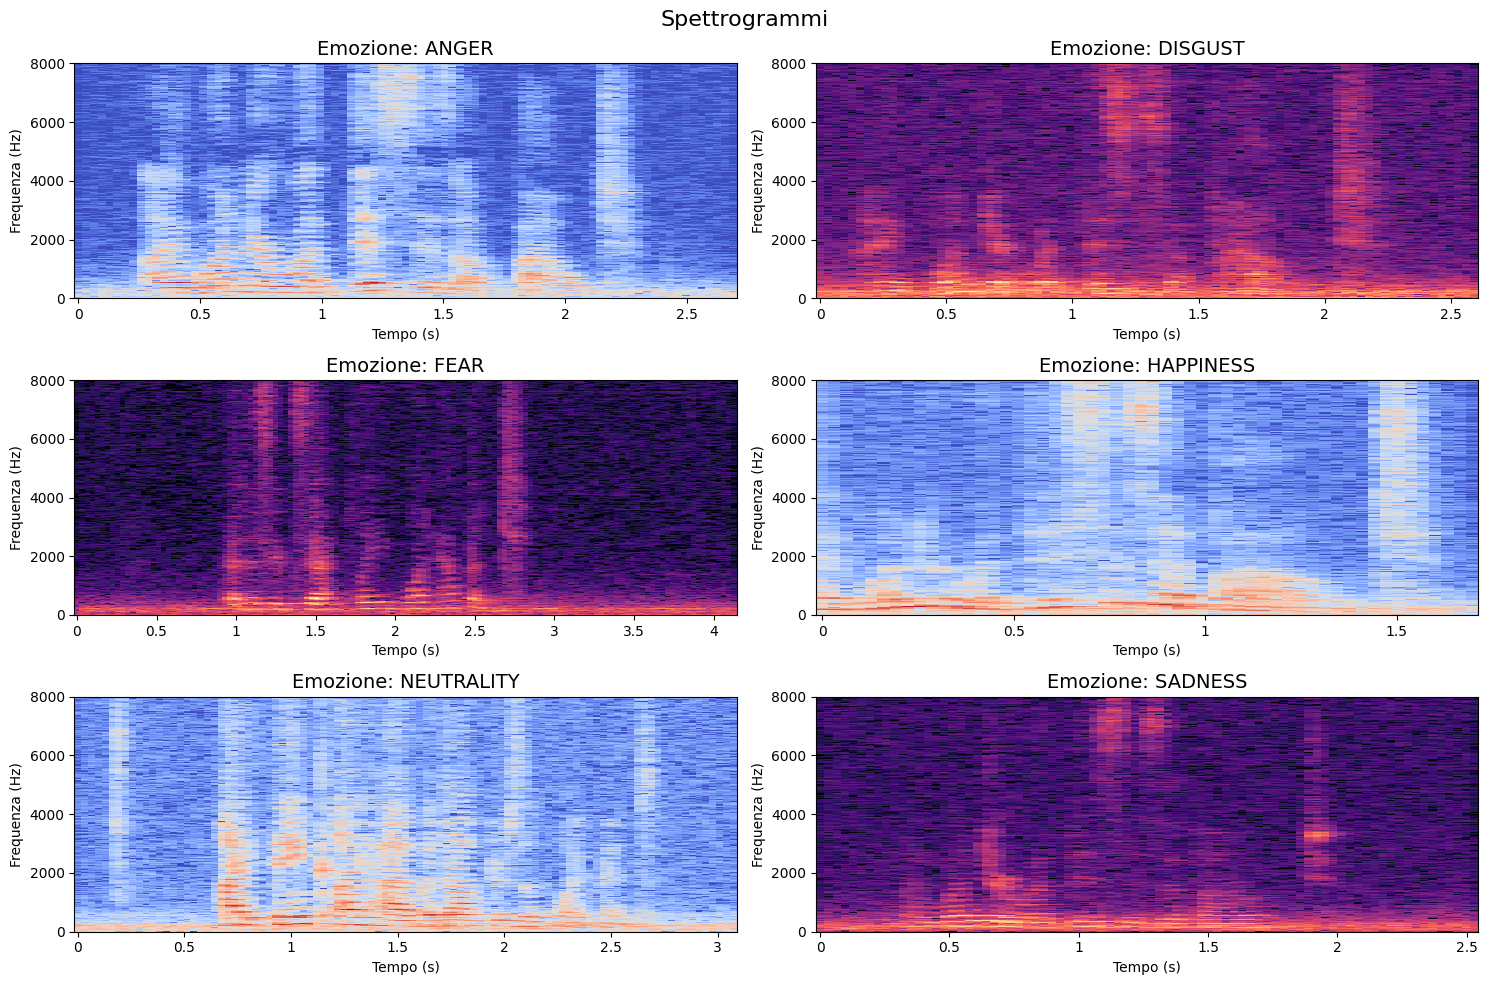

In [ ]:
# Visualizzazione degli spettrogrammi

plot_grid_3x2(df, spectogram, 'Spettrogrammi')

# ANALISI DEL CASO 1
### 5 CARATTERISTICHE ESTRATTE

In [ ]:
# Lettura del dataset

base_df = pd.read_pickle('/content/drive/MyDrive/ABEC/Base.pkl')

In [ ]:
# Statitiche del dataset

base_df.shape

(37210, 6)

In [ ]:
# Rimozione delle classi misclassificate

base_df = base_df[~base_df['label'].isin(['FEAR', 'NEUTRALITY'])]

In [ ]:
# Statitiche del dataset aggiornato

base_df.shape

(25420, 6)

In [ ]:
base_df.head()

,mfcc,chroma,mel,tonnetz,spectral_contrast,label
0,"[-346.29526, 137.64049, 8.69169, 35.311882, -9...","[0.29201826, 0.38502562, 0.29120973, 0.3123079...","[0.07737846, 0.034783144, 0.04425149, 0.062268...","[-0.0430883237494016, -0.05187423004202757, -0...","[13.31842625645253, 16.873059068316007, 20.454...",ANGER
1,"[-219.8249125923227, 50.341959573400786, 24.00...","[0.37295172403725513, 0.4456591592543497, 0.36...","[0.08566669235276622, 0.038954595977661884, 0....","[-0.04746918356733313, -0.055986936911153695, ...","[12.812264239583778, 16.260028732231927, 18.94...",ANGER
2,"[-375.05515, 132.2356, 10.073215, 30.356653, -...","[0.29833022, 0.37963942, 0.2675938, 0.32496527...","[0.037430894, 0.015797297, 0.018807301, 0.0287...","[-0.07300732215248174, -0.052441760849361405, ...","[14.125213326380202, 17.16686360031749, 21.117...",ANGER
3,"[-342.96893, 136.74147, 9.398659, 34.11375, -9...","[0.29580083, 0.38224933, 0.29990616, 0.3125384...","[0.07729194, 0.035300333, 0.04430152, 0.063042...","[-0.07487064684248107, -0.06240115248358825, -...","[13.124703766932965, 16.246416542043036, 20.95...",ANGER
4,"[-345.86893, 116.51579, 9.756774, 5.285912, -7...","[0.2184162, 0.2955816, 0.3488706, 0.49626875, ...","[0.027997933, 0.019921398, 0.008562651, 0.0155...","[-0.08157975611316184, -0.008267977533426438, ...","[13.975499943771492, 16.00863120845709, 21.480...",ANGER


In [ ]:
# Divisione in etichette e dati

X_5 = base_df[['mfcc', 'chroma', 'mel', 'tonnetz', 'spectral_contrast']].apply(
    safe_concatenate, axis=1).tolist()
y_5 = base_df['label']
X_5 = np.array(X_5)
y_5 = np.array(y_5)
X_5, y_5

(array([[-346.29525757,  137.64048767,    8.69169044, ...,   17.71552744,
           18.37050703,   64.55771774],
        [-219.82491259,   50.34195957,   24.0035798 , ...,   14.93604804,
           14.12919573,   13.83347917],
        [-375.05514526,  132.2355957 ,   10.07321453, ...,   18.86536027,
           19.59152481,   64.17512924],
        ...,
        [-470.80865479,  155.6711731 ,   12.9026289 , ...,   16.89418463,
           15.71497143,   65.8139882 ],
        [-433.63983154,  155.80548096,   15.16045761, ...,   16.11573302,
           14.58124379,   64.79614981],
        [-428.23419189,  137.38552856,   25.98892593, ...,   19.18687328,
           17.9013894 ,   45.81103134]]),
 array(['ANGER', 'ANGER', 'ANGER', ..., 'SADNESS', 'SADNESS', 'SADNESS'],
       dtype=object))

In [ ]:
# Randomizzazione

X_5, y_5 = shuffle(X_5, y_5, random_state=42)
X_5, y_5

(array([[-376.27668905,   44.35100886,   39.3604124 , ...,   13.74553973,
           14.40757225,   14.66075115],
        [-450.64129639,  117.1810379 ,   41.07022858, ...,   18.88185173,
           17.34146296,   46.13279923],
        [-426.96536255,  139.54241943,    1.40641117, ...,   17.71715959,
           16.62880835,   65.36838893],
        ...,
        [-415.58892822,  155.20239258,   16.72205353, ...,   16.09951531,
           15.28836103,   65.72182145],
        [-428.81207275,  153.75828552,   17.93458748, ...,   15.98037124,
           15.71889106,   63.35017881],
        [-445.24798584,  114.08211517,   40.51183701, ...,   19.46117122,
           18.5951385 ,   45.33654792]]),
 array(['SADNESS', 'ANGER', 'SADNESS', ..., 'ANGER', 'HAPPINESS',
        'SADNESS'], dtype=object))

In [ ]:
# Splitting

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_index, test_index in skf.split(X_5, y_5):
    X_train_5, X_temp = X_5[train_index], X_5[test_index]
    y_train_5, y_temp = y_5[train_index], y_5[test_index]
    val_split = int(0.3 * len(X_temp))
    X_val_5, X_test_5 = X_temp[:val_split], X_temp[val_split:]
    y_val_5, y_test_5 = y_temp[:val_split], y_temp[val_split:]
    folds.append((X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5))

<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')


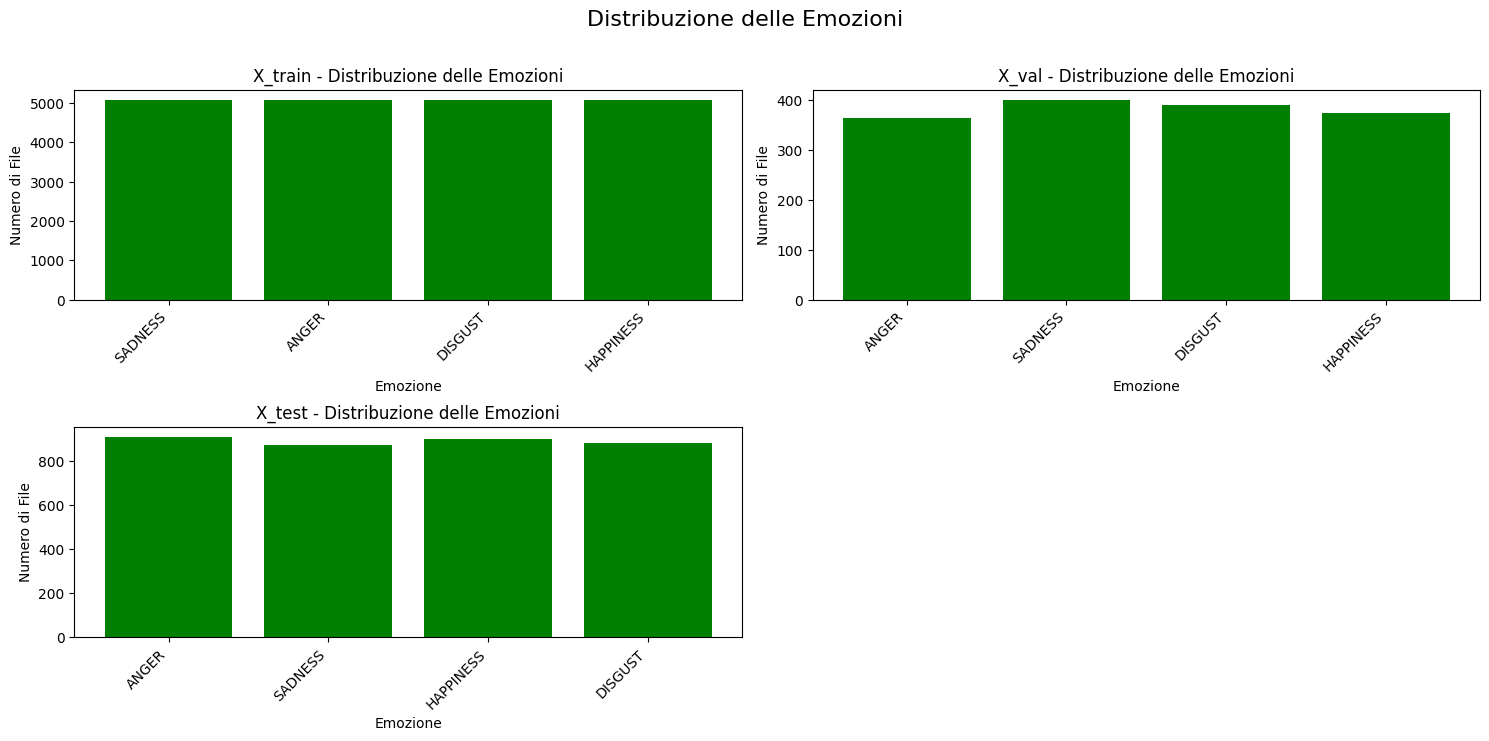

In [ ]:
# Controllo della distribuzione delle emozioni dopo lo splitting

X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5 = folds[0]
train_emotion_counts = Counter(y_train_5)
val_emotion_counts = Counter(y_val_5)
test_emotion_counts = Counter(y_test_5)
plot_emotion_distributions(train_emotion_counts, val_emotion_counts, test_emotion_counts)

In [ ]:
X_train_5.shape, X_val_5.shape, X_test_5.shape, y_train_5.shape, y_val_5.shape, y_test_5.shape

((20336, 193), (1525, 193), (3559, 193), (20336,), (1525,), (3559,))

In [ ]:
# Reshaping

X_train_res_5 = X_train_5.reshape((X_train_5.shape[0], X_train_5.shape[1], 1))
X_test_res_5 = X_test_5.reshape((X_test_5.shape[0], X_test_5.shape[1], 1))
X_val_res_5 = X_val_5.reshape((X_val_5.shape[0], X_val_5.shape[1], 1))

In [ ]:
X_train_res_5.shape, X_val_res_5.shape, X_test_res_5.shape

((20336, 193, 1), (1525, 193, 1), (3559, 193, 1))

In [ ]:
# One-Hot Enconding

encoder = OneHotEncoder(sparse_output=False)
y_train_enc_5 = encoder.fit_transform(y_train_5.reshape(-1, 1))
y_test_enc_5 = encoder.transform(y_test_5.reshape(-1, 1))
y_val_enc_5 = encoder.transform(y_val_5.reshape(-1, 1))

In [ ]:
y_train_enc_5.shape, y_test_enc_5.shape, y_val_enc_5.shape

((20336, 4), (3559, 4), (1525, 4))

In [ ]:
# Creazione del modello

model5 = Sequential()
model5.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_res_5.shape[1], X_train_res_5.shape[2])))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(y_train_enc_5.shape[1], activation='softmax'))
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 191, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 95, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 95, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 93, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 46, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 46, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5888)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         376,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,116 (1.53 MB)

 Trainable params: 402,116 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting

history = model5.fit(X_train_res_5, y_train_enc_5, validation_data=(X_val_res_5, y_val_enc_5), epochs=100, batch_size=32)

Epoch 1/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.4806 - loss: 1.2620 - val_accuracy: 0.5757 - val_loss: 0.9810
Epoch 2/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - accuracy: 0.5634 - loss: 0.9837 - val_accuracy: 0.5849 - val_loss: 0.9477
Epoch 3/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.5827 - loss: 0.9390 - val_accuracy: 0.5856 - val_loss: 0.9515
Epoch 4/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.5932 - loss: 0.9246 - val_accuracy: 0.6085 - val_loss: 0.9105
Epoch 5/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6014 - loss: 0.9071 - val_accuracy: 0.6085 - val_loss: 0.8929
Epoch 6/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6121 - loss: 0.8868 - val_accuracy: 0.6164 - val_loss: 0.8826
Epoch 7/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.6245 - loss: 0.8597 - val_accuracy: 0.6177 - val_loss: 0.8785
Epoch 8/100
636/636 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.6359 - loss: 0

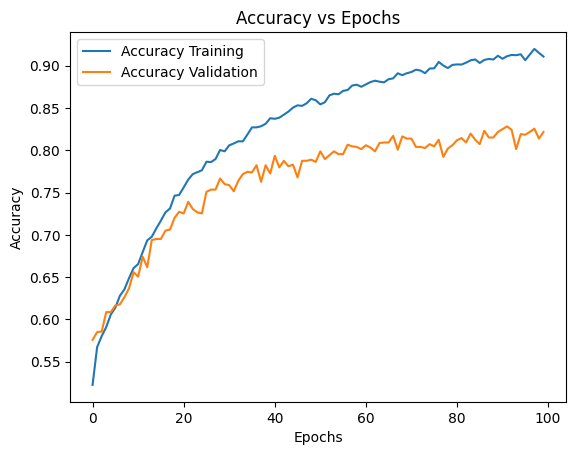

In [ ]:
# Andamento accuracy

plt.plot(history.history['accuracy'], label='Accuracy Training')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

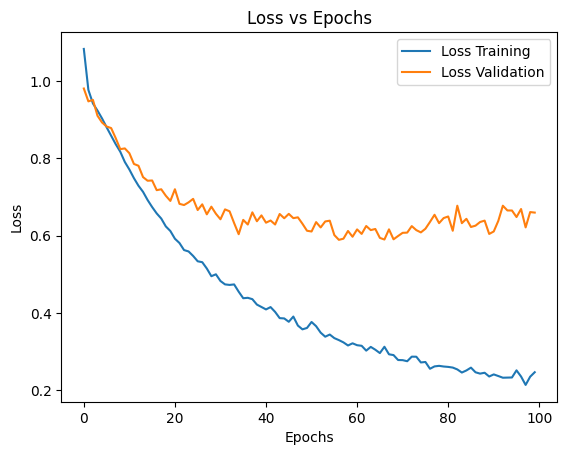

In [ ]:
# Andamento loss

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Valutazione del modello

accuracy_5 = model5.evaluate(X_test_res_5, y_test_enc_5)
print(f"Test Accuracy: {100*accuracy_5[1]:.2f}%")

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8204 - loss: 0.6833
Test Accuracy: 81.88%


In [ ]:
y_pred_5 = model5.predict(X_test_res_5)
y_pred_enc_5 = np.argmax(y_pred_5, axis=1)
y_test_encoded_5 = np.argmax(y_test_enc_5, axis=1)

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [ ]:
print("Rapporto di classificazione:")
print(classification_report(y_test_encoded_5, y_pred_enc_5, target_names=np.unique(y_5)))

Rapporto di classificazione:
              precision    recall  f1-score   support

       ANGER       0.90      0.87      0.88       908
     DISGUST       0.75      0.79      0.77       882
   HAPPINESS       0.81      0.77      0.79       898
     SADNESS       0.83      0.84      0.83       871

    accuracy                           0.82      3559
   macro avg       0.82      0.82      0.82      3559
weighted avg       0.82      0.82      0.82      3559



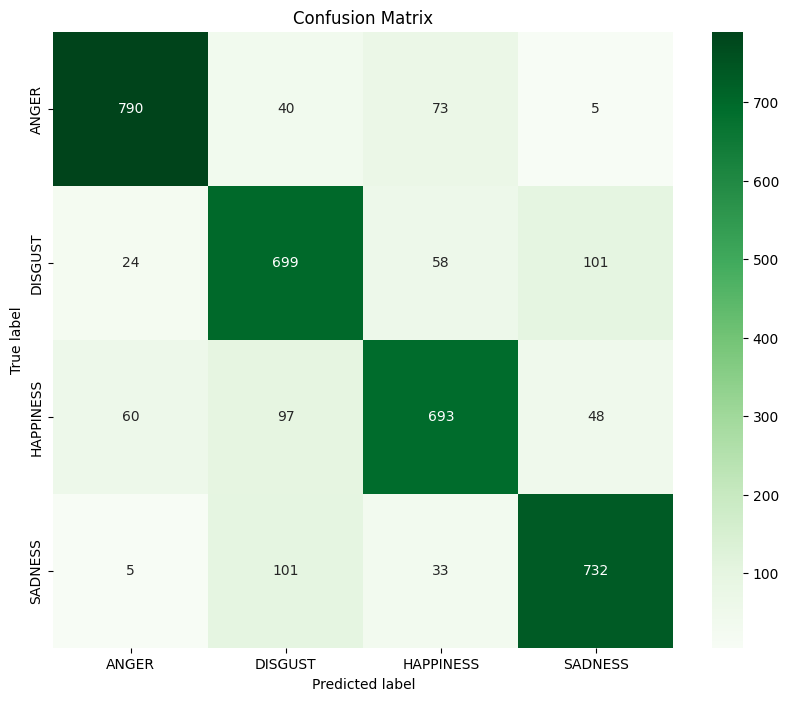

In [ ]:
# Matrice di confusione

conf_matrix = confusion_matrix(y_test_encoded_5, y_pred_enc_5)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_5), yticklabels=np.unique(y_5))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Dizionario di mapping delle etichette numeriche ai nomi delle emozioni

label_to_emotion = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Neutrality",
    5: "Sadness"
}

In [ ]:
# Identificazione delle etichette misclassificate

misclassified_indices = np.where(y_test_encoded_5 != y_pred_enc_5)[0]
misclassified_labels = y_test_encoded_5[misclassified_indices]
predicted_labels = y_pred_enc_5[misclassified_indices]
misclassification_counts = Counter(zip(misclassified_labels, predicted_labels))
total_counts = Counter(y_test_encoded_5)
misclassification_percentage = {}

for (true_label, predicted_label), count in misclassification_counts.items():
    if true_label not in misclassification_percentage:
        misclassification_percentage[true_label] = 0
    misclassification_percentage[true_label] += count

for label in total_counts:
    if label in misclassification_percentage:
        misclassification_percentage[label] = (misclassification_percentage[label] / total_counts[label]) * 100
    else:
        misclassification_percentage[label] = 0.0
sorted_misclassification = sorted(misclassification_percentage.items(), key=lambda x: x[1], reverse=True)
print("\nPercentuale di misclassificazione per emozione:\n" + "-"*50)
print(f"{'Emozione':<15} {'Percentuale (%)':<15}")
print("-"*50)
for label, percentage in sorted_misclassification:
    emotion_name = label_to_emotion.get(label, "Unknown")
    print(f"{emotion_name:<15} {percentage:<15.2f}")
print("-"*50)


Percentuale di misclassificazione per emozione:
--------------------------------------------------
Emozione        Percentuale (%)
--------------------------------------------------
Fear            22.83          
Disgust         20.75          
Happiness       15.96          
Anger           13.00          
--------------------------------------------------


# ANALISI DEL CASO 2
### 10 CARATTERISTICHE ESTRATTE

In [ ]:
# Lettura del dataset

total_df = pd.read_pickle('/content/drive/MyDrive/ABEC/Totale.pkl')

In [ ]:
# Statitiche del dataset

total_df.shape

(37210, 11)

In [ ]:
# Rimozione delle classi misclassificate

total_df = total_df[~total_df['label'].isin(['FEAR', 'SADNESS'])]

In [ ]:
# Statistiche del dataset aggiornato

total_df.shape

(24500, 11)

In [ ]:
total_df.head()

,mfcc,chroma,mel,tonnetz,spectral_contrast,label,zero-crossing,hnr,teo,ste,psd
0,"[-346.29526, 137.64049, 8.69169, 35.311882, -9...","[0.2920183, 0.38502562, 0.2912098, 0.31230795,...","[0.07737846, 0.034783144, 0.04425149, 0.062268...","[-0.04308832620094756, -0.05187422960465165, -...","[13.31842625645253, 16.873059068316007, 20.454...",ANGER,[0.06904810855263158],4.752542,[0.037368394],[0.037368394],118.536977
1,"[-217.63794149359478, 49.28205334748398, 22.94...","[0.4014266020984078, 0.43750606936592107, 0.35...","[0.08338412091243652, 0.03848436835809863, 0.0...","[-0.06359820754670203, -0.06454893386041949, -...","[12.890606598116435, 15.678900169505514, 18.72...",ANGER,[0.07244037828947368],4.794090,[0.03737672],[0.03737672],118.550563
2,"[-375.05515, 132.2356, 10.073214, 30.356653, -...","[0.2983302, 0.37963948, 0.2675938, 0.32496527,...","[0.037430894, 0.015797297, 0.018807301, 0.0287...","[-0.0730073225326384, -0.052441762890201374, -...","[14.125213326380202, 17.16686360031749, 21.117...",ANGER,[0.07325860031512606],5.701991,[0.026131568],[0.026131568],74.026113
3,"[-342.77963, 136.20628, 9.508022, 34.045036, -...","[0.30809242, 0.3929714, 0.28056914, 0.3146813,...","[0.079606466, 0.036074568, 0.048042264, 0.0664...","[-0.05580208454991028, -0.059141703335278996, ...","[12.750848176142707, 16.4360380291664, 21.2006...",ANGER,[0.06941817434210526],3.996771,[0.037620563],[0.037620563],118.536977
4,"[-345.86896, 116.51581, 9.756775, 5.285911, -7...","[0.21841621, 0.2955816, 0.3488706, 0.49626878,...","[0.027997933, 0.019921398, 0.008562651, 0.0155...","[-0.08157975782800166, -0.008267978011115475, ...","[13.975499943771492, 16.00863120845709, 21.480...",ANGER,[0.09182771381578947],2.037568,[0.027112331],[0.027112331],63.006963


In [ ]:
# Divisione in etichette e dati

X_10 = total_df[['mfcc', 'chroma', 'mel', 'tonnetz', 'spectral_contrast', 'zero-crossing', 'hnr', 'teo', 'ste', 'psd']].apply(
    safe_concatenate, axis=1).tolist()
y_10 = total_df['label']
X_10 = np.array(X_10)
y_10 = np.array(y_10)
X_10, y_10

(array([[-3.46295258e+02,  1.37640488e+02,  8.69169044e+00, ...,
          3.73683944e-02,  3.73683944e-02,  1.18536977e+02],
        [-2.17637941e+02,  4.92820533e+01,  2.29487878e+01, ...,
          3.73767205e-02,  3.73767205e-02,  1.18550563e+02],
        [-3.75055145e+02,  1.32235596e+02,  1.00732136e+01, ...,
          2.61315685e-02,  2.61315685e-02,  7.40261127e+01],
        ...,
        [-4.23971008e+02,  1.37108170e+02,  6.54681015e+00, ...,
          1.32783139e-02,  1.32783139e-02,  1.55429874e+01],
        [-3.88396942e+02,  1.42292633e+02,  3.59248948e+00, ...,
          1.83164943e-02,  1.83164943e-02,  2.16563830e+01],
        [-3.92239624e+02,  1.16973839e+02,  1.29144030e+01, ...,
          1.24370111e-02,  1.24370111e-02,  1.12605085e+01]]),
 array(['ANGER', 'ANGER', 'ANGER', ..., 'NEUTRALITY', 'NEUTRALITY',
        'NEUTRALITY'], dtype=object))

In [ ]:
# Randomizzazione

X_10, y_10 = shuffle(X_10, y_10, random_state=42)
X_10, y_10

(array([[-4.01055450e+02,  1.09378769e+02,  1.85367775e+01, ...,
          8.27074610e-03,  8.27074610e-03,  4.33714913e+00],
        [-3.88783242e+02,  7.69125381e+01,  2.84768284e+01, ...,
          9.06666555e-03,  9.06666555e-03,  8.49140174e+00],
        [-2.37846451e+02,  9.85681915e+01, -2.15101566e+01, ...,
          1.08263567e-01,  1.08263567e-01,  8.70601348e+02],
        ...,
        [-4.15588928e+02,  1.55202393e+02,  1.67220535e+01, ...,
          1.32566523e-02,  1.32566523e-02,  1.38155247e+01],
        [-4.28812073e+02,  1.53758286e+02,  1.79345875e+01, ...,
          1.19095454e-02,  1.19095454e-02,  8.82090374e+00],
        [-3.76770752e+02,  8.51556702e+01,  3.15559158e+01, ...,
          1.13018742e-02,  1.13018742e-02,  7.86018938e+00]]),
 array(['HAPPINESS', 'NEUTRALITY', 'ANGER', ..., 'ANGER', 'HAPPINESS',
        'NEUTRALITY'], dtype=object))

In [ ]:
# Splitting

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_index, test_index in skf.split(X_10, y_10):
    X_train_10, X_temp = X_10[train_index], X_10[test_index]
    y_train_10, y_temp = y_10[train_index], y_10[test_index]
    val_split = int(0.3 * len(X_temp))
    X_val_10, X_test_10 = X_temp[:val_split], X_temp[val_split:]
    y_val_10, y_test_10 = y_temp[:val_split], y_temp[val_split:]
    folds.append((X_train_10, X_val_10, X_test_10, y_train_10, y_val_10, y_test_10))

In [ ]:
X_train_10.shape, X_val_10.shape, X_test_10.shape, y_train_10.shape, y_val_10.shape, y_test_10.shape

((19600, 198), (1470, 198), (3430, 198), (19600,), (1470,), (3430,))

<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')


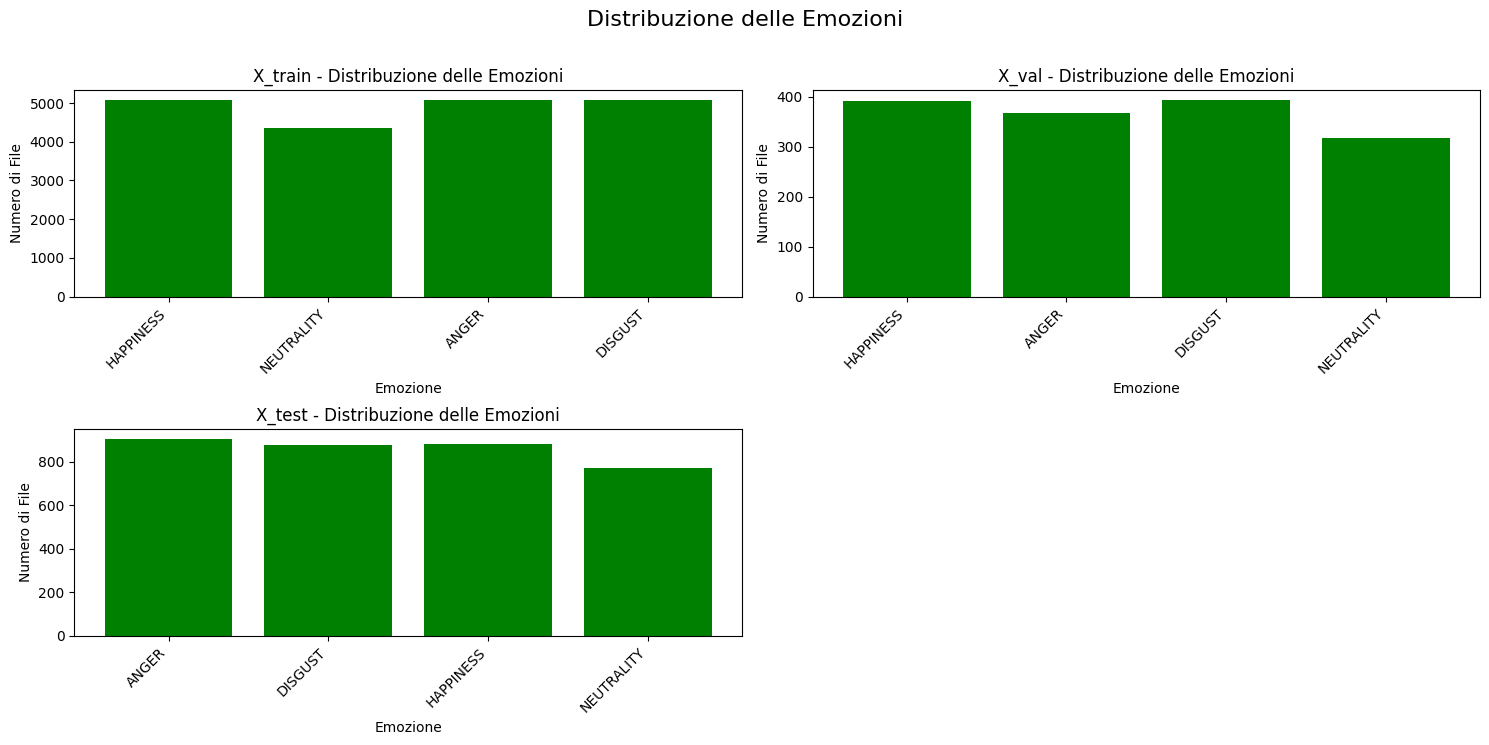

In [ ]:
# Controllo della distribuzione delle emozioni dopo lo splitting

X_train_10, X_val_10, X_test_10, y_train_10, y_val_10, y_test_10 = folds[0]
train_emotion_counts = Counter(y_train_10)
val_emotion_counts = Counter(y_val_10)
test_emotion_counts = Counter(y_test_10)
plot_emotion_distributions(train_emotion_counts, val_emotion_counts, test_emotion_counts)

In [ ]:
# Reshaping

X_train_res_10 = X_train_10.reshape((X_train_10.shape[0], X_train_10.shape[1], 1))
X_test_res_10 = X_test_10.reshape((X_test_10.shape[0], X_test_10.shape[1], 1))
X_val_res_10 = X_val_10.reshape((X_val_10.shape[0], X_val_10.shape[1], 1))

In [ ]:
X_train_res_10.shape, X_val_res_10.shape, X_test_res_10.shape

((19600, 198, 1), (1470, 198, 1), (3430, 198, 1))

In [ ]:
# One-Hot Enconding

encoder = OneHotEncoder(sparse_output=False)
y_train_enc_10 = encoder.fit_transform(y_train_10.reshape(-1, 1))
y_test_enc_10 = encoder.transform(y_test_10.reshape(-1, 1))
y_val_enc_10 = encoder.transform(y_val_10.reshape(-1, 1))

In [ ]:
y_train_enc_10.shape, y_test_enc_10.shape, y_val_enc_10.shape

((19600, 4), (3430, 4), (1470, 4))

In [ ]:
# Creazione del modello

model10 = Sequential()
model10.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_res_10.shape[1], X_train_res_10.shape[2])))
model10.add(MaxPooling1D(pool_size=2))
model10.add(Dropout(0.2))
model10.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model10.add(MaxPooling1D(pool_size=2))
model10.add(Dropout(0.2))
model10.add(Flatten())
model10.add(Dense(64, activation='relu'))
model10.add(Dense(y_train_enc_10.shape[1], activation='softmax'))
model10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model10.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 196, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 96, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         393,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,500 (1.60 MB)

 Trainable params: 418,500 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fitting

history = model10.fit(X_train_res_10, y_train_enc_10, validation_data=(X_val_res_10, y_val_enc_10), epochs=100, batch_size=32)

Epoch 1/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.4439 - loss: 1.3216 - val_accuracy: 0.5531 - val_loss: 1.0290
Epoch 2/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5335 - loss: 1.0470 - val_accuracy: 0.5769 - val_loss: 0.9969
Epoch 3/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5465 - loss: 1.0197 - val_accuracy: 0.5694 - val_loss: 0.9978
Epoch 4/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5656 - loss: 0.9974 - val_accuracy: 0.6041 - val_loss: 0.9384
Epoch 5/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.5852 - loss: 0.9582 - val_accuracy: 0.6163 - val_loss: 0.9329
Epoch 6/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.5840 - loss: 0.9578 - val_accuracy: 0.6075 - val_loss: 0.9065
Epoch 7/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.5956 - loss: 0.9317 - val_accuracy: 0.6211 - val_loss: 0.8910
Epoch 8/100
613/613 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.6117 - loss: 0

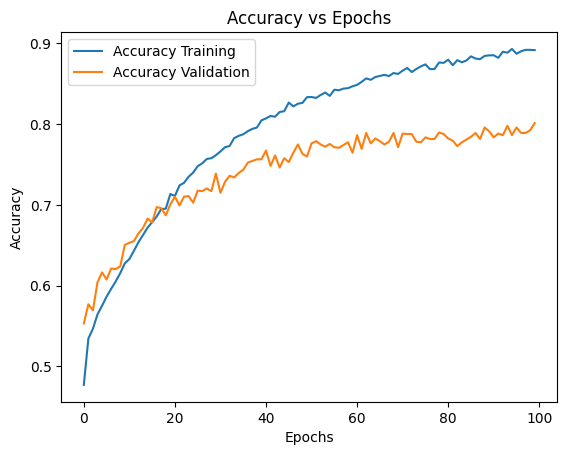

In [ ]:
# Andamento accuracy

plt.plot(history.history['accuracy'], label='Accuracy Training')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

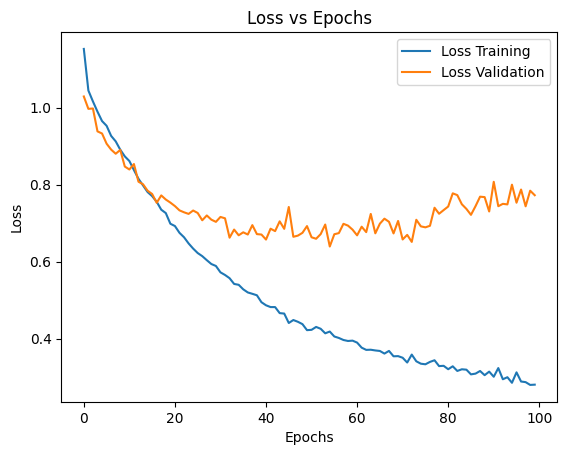

In [ ]:
# Andamento loss

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Valutazione del modello

accuracy_10 = model10.evaluate(X_test_res_10, y_test_enc_10)
print(f"Test Accuracy: {100*accuracy_10[1]:.2f}%")

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7692 - loss: 0.9283
Test Accuracy: 78.08%


In [ ]:
y_pred_10 = model10.predict(X_test_res_10)
y_pred_enc_10 = np.argmax(y_pred_10, axis=1)
y_test_encoded_10 = np.argmax(y_test_enc_10, axis=1)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
print("Rapporto di classificazione:")
print(classification_report(y_test_encoded_10, y_pred_enc_10, target_names=np.unique(y_10)))

Rapporto di classificazione:
              precision    recall  f1-score   support

       ANGER       0.90      0.80      0.85       904
     DISGUST       0.72      0.77      0.74       877
   HAPPINESS       0.77      0.75      0.76       880
  NEUTRALITY       0.75      0.80      0.77       769

    accuracy                           0.78      3430
   macro avg       0.78      0.78      0.78      3430
weighted avg       0.79      0.78      0.78      3430



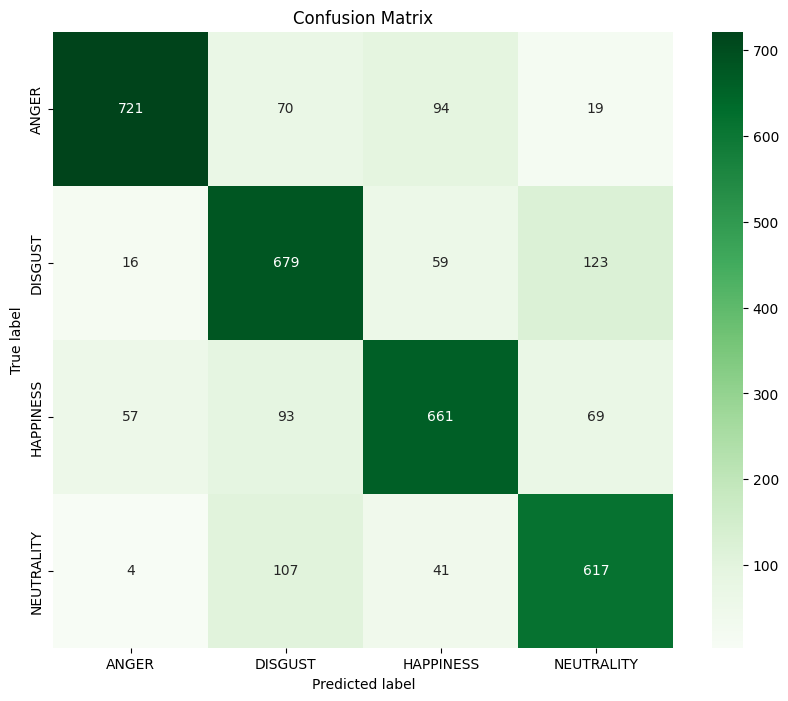

In [ ]:
# Matrice di confusione

conf_matrix = confusion_matrix(y_test_encoded_10, y_pred_enc_10)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_10), yticklabels=np.unique(y_10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Dizionario di mapping delle etichette numeriche ai nomi delle emozioni

label_to_emotion = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Neutrality",
    5: "Sadness"
}

In [ ]:
# Identificazione delle etichette misclassificate

misclassified_indices = np.where(y_test_encoded_10 != y_pred_enc_10)[0]
misclassified_labels = y_test_encoded_10[misclassified_indices]
predicted_labels = y_pred_enc_10[misclassified_indices]
misclassification_counts = Counter(zip(misclassified_labels, predicted_labels))
total_counts = Counter(y_test_encoded_10)
misclassification_percentage = {}

for (true_label, predicted_label), count in misclassification_counts.items():
    if true_label not in misclassification_percentage:
        misclassification_percentage[true_label] = 0
    misclassification_percentage[true_label] += count

for label in total_counts:
    if label in misclassification_percentage:
        misclassification_percentage[label] = (misclassification_percentage[label] / total_counts[label]) * 100
    else:
        misclassification_percentage[label] = 0.0
sorted_misclassification = sorted(misclassification_percentage.items(), key=lambda x: x[1], reverse=True)
print("\nPercentuale di misclassificazione per emozione:\n" + "-"*50)
print(f"{'Emozione':<15} {'Percentuale (%)':<15}")
print("-"*50)
for label, percentage in sorted_misclassification:
    emotion_name = label_to_emotion.get(label, "Unknown")
    print(f"{emotion_name:<15} {percentage:<15.2f}")
print("-"*50)


Percentuale di misclassificazione per emozione:
--------------------------------------------------
Emozione        Percentuale (%)
--------------------------------------------------
Fear            24.89          
Disgust         22.58          
Anger           20.24          
Happiness       19.77          
--------------------------------------------------


# VALUTAZIONI CONCLUSIVE

In [ ]:
# Valutazione caso 1

acc5 = accuracy_score(y_test_encoded_5, y_pred_enc_5)
prec5 = precision_score(y_test_encoded_5, y_pred_enc_5, average='weighted')
rec5 = recall_score(y_test_encoded_5, y_pred_enc_5, average='weighted')
f15 = f1_score(y_test_encoded_5, y_pred_enc_5, average='weighted')
acc5 = f"{acc5 * 100:.2f}%"
prec5 = f"{prec5 * 100:.2f}%"
rec5 = f"{rec5 * 100:.2f}%"
f15 = f"{f15 * 100:.2f}%"

In [ ]:
# Valutazione caso 2

acc10 = accuracy_score(y_test_encoded_10, y_pred_enc_10)
prec10 = precision_score(y_test_encoded_10, y_pred_enc_10, average='weighted')
rec10 = recall_score(y_test_encoded_10, y_pred_enc_10, average='weighted')
f110 = f1_score(y_test_encoded_10, y_pred_enc_10, average='weighted')
acc10 = f"{acc10 * 100:.2f}%"
prec10 = f"{prec10 * 100:.2f}%"
rec10 = f"{rec10 * 100:.2f}%"
f110 = f"{f110 * 100:.2f}%"

In [ ]:
# Valutazione finale

data = {
    'Metriche': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Modello con 5 caratteristiche': [acc5, prec5, rec5, f15],
    'Modello con 10 caratteristiche': [acc10, prec10, rec10, f110]
}
results = pd.DataFrame(data)
display(results)

,Metriche,Modello con 5 caratteristiche,Modello con 10 caratteristiche
0,Accuracy,81.88%,78.08%
1,Precision,82.04%,78.65%
2,Recall,81.88%,78.08%
3,F1-score,81.92%,78.22%
